

---


# **Combination of Dataframes and ML prediction**
#### ***Look before you Leap : Leveraging Predictive Models to Improve Automotive Safety and Travel Time***



---



**Final Project**
CSCI 35300/79502 

##### Hannah Do







In [247]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random, math

import datetime
import string, re
import sys, os

from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from collections import Counter

In [2]:
! pip install imbalanced-learn


In [3]:
import imblearn
print(imblearn.__version__)

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

0.8.0


---
### Merging dataframes - traffic + tweet
- Importing previously saved csv files

In [4]:
file_1mo = ['locat_11a', 'locat_11b']
file_3mo = ['locat_9a', 'locat_9b', 'locat_10a', 'locat_10b', 'locat_11a', 'locat_11b']
file_6mo = ['locat_6a', 'locat_6b', 'locat_7a', 'locat_7b', 'locat_8a', 'locat_9a', 'locat_9b', 'locat_10a', 'locat_10b', 'locat_11a', 'locat_11b']


In [63]:
tweet = pd.DataFrame()

for f in file_1mo:
    
    file = pd.read_csv('locat/' +f + '.csv')

    file = file.drop(columns = ['Unnamed: 0'], axis=1)

    file['longitude'] = file['longitude'].apply(lambda x: float(x))
    file['latitude'] = file['latitude'].apply(lambda x: float(x))

    file = file[file['latitude'] > 40.5]
    file = file[file['latitude'] < 41]
    file = file[file['longitude'] < -73]
    file = file[file['longitude'] > -75]

    file = file.reset_index(drop=True)
    
    tweet = tweet.append(file)

tweet = tweet.reset_index(drop=True)
tweet

,original tweet,neutral score,polar score,trimmed tweet,latitude,longitude
0,Cleared: Incident on #NY156,0.682,0.1027,cleared incident new york 156,40.702568,-74.01145
1,Incident on #I287 SB at North of Exit 1 - US 1...,1.000,0.0000,incident i287 south bound route h exit 1 us 1 ...,40.714550,-74.00714
2,Cleared: Incident on #NJ17 NB from I-80 to Pas...,0.865,0.1027,cleared incident new jersey 17 route h bound 8...,40.860340,-74.12374
3,Updated: Incident on #NY32 at Sweet Road https...,0.700,0.4588,updated incident new york 32 sweet road https ...,40.714550,-74.00714
4,Incident on #ALine at Aqueduct - N Conduit Av ...,1.000,0.0000,incident aline aqueduct n conduit av https co ...,40.668180,-73.83918
...,...,...,...,...,...,...
20009,Cleared: Construction on #NY19 NB from Beadle ...,0.865,0.1027,cleared construction new york 19 route h bound...,40.714550,-74.00714
20010,Cleared: Construction on #NY18 WB from Wiler R...,0.887,0.1027,cleared construction new york 18 west bound wi...,40.714550,-74.00714
20011,Cleared: Incident on #StatenIslandRailway NB f...,0.865,0.1027,cleared incident staten island rail way route ...,40.644550,-74.08014
20012,Cleared: Construction on #NY77 NB at Broadway;...,0.851,0.1027,cleared construction new york 77 route h bound...,40.868736,-73.91793


In [241]:
traffic = pd.read_csv("data_traffic/accident_1mo.csv", index_col= None, header = None)
# data_traffic/accident_1mo.csv
# data_traffic/accident_6mo.csv

traffic = traffic.drop([0], axis=1)
# drop NaN column with index values

traffic.columns = traffic.iloc[0]
traffic = traffic[1:] 
# make first row as column names
    
traffic

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
1,2020-11-30,1:10,STATEN ISLAND,10305,40.59742,-74.06836,"(40.59742, -74.06836)",MCCLEAN AVENUE,WALLACE AVENUE,0,...,0,0,0,0,0,Unspecified,NaN,4371841,Sedan,NaN
2,2020-11-29,11:55,NaN,NaN,40.844955,-73.93008,"(40.844955, -73.93008)",HARLEM RIVER DRIVE,NaN,0,...,0,0,0,0,0,Unsafe Speed,NaN,4371752,Sedan,NaN
3,2020-11-28,18:00,QUEENS,11420,40.677505,-73.81786,"(40.677505, -73.81786)",115 AVENUE,121 STREET,2,...,0,0,0,2,0,Driver Inattention/Distraction,Unspecified,4371339,Taxi,Sedan
4,2020-11-28,7:45,NaN,NaN,40.72948,-73.9721,"(40.72948, -73.9721)",FDR DRIVE,NaN,0,...,0,0,0,0,0,Brakes Defective,NaN,4371325,Sedan,NaN
5,2020-11-27,9:27,NaN,NaN,40.669857,-73.95051,"(40.669857, -73.95051)",NOSTRAND AVENUE,NaN,1,...,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,4371303,Sedan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7904,2020-11-07,9:08,BRONX,10452,40.838383,-73.91902,"(40.838383, -73.91902)",JEROME AVENUE,EAST CLARKE PLACE,0,...,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,4365629,Taxi,Sedan
7905,2020-11-08,0:01,QUEENS,11354,40.76407,-73.80914,"(40.76407, -73.80914)",156 STREET,NORTHERN BOULEVARD,0,...,0,0,0,0,0,Aggressive Driving/Road Rage,NaN,4365395,Sedan,NaN
7906,2020-11-09,23:20,BROOKLYN,11238,40.67329,-73.95703,"(40.67329, -73.95703)",FRANKLIN AVENUE,STERLING PLACE,3,...,0,0,0,3,0,Driver Inattention/Distraction,Unspecified,4366610,Sedan,Sedan
7907,2020-11-24,13:30,QUEENS,11433,40.704185,-73.78599,"(40.704185, -73.78599)",172 STREET,LIBERTY AVENUE,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,4370790,PK,Sedan


In [242]:
traffic = traffic.dropna(subset=['LONGITUDE', 'LATITUDE'])

traffic['LONGITUDE'] = traffic['LONGITUDE'].apply(lambda x: float(x))
traffic['LATITUDE'] = traffic['LATITUDE'].apply(lambda x: float(x))

# remove out of range
traffic = traffic[traffic['LATITUDE'] > 40.5]
traffic = traffic[traffic['LATITUDE'] < 41]
traffic = traffic[traffic['LONGITUDE'] < -73]
traffic = traffic[traffic['LONGITUDE'] > -75]

traffic = traffic.reset_index(drop=True)


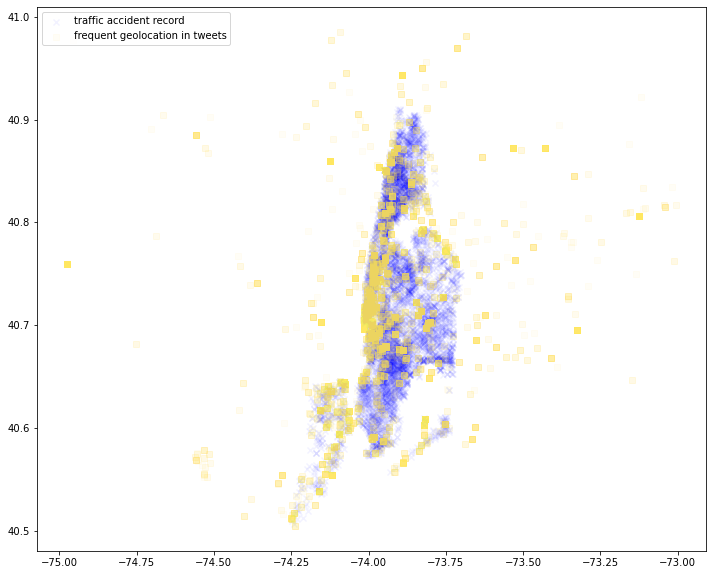

In [243]:
# visualizing the similarity between accident record and twitter geolocations

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.scatter(traffic['LONGITUDE'],traffic['LATITUDE'], c='b', alpha=0.05, marker='x', label='traffic accident record')

plt.scatter(tweet['longitude'], tweet['latitude'], c='#FFE760', alpha=0.05, marker='s', label='frequent geolocation in tweets')

plt.legend(loc='upper left')
plt.show()


In [245]:

tweet_sorted = tweet.groupby(["longitude", "latitude"]).size().reset_index(name="frequency")
tweet_sorted = tweet_sorted.sort_values('frequency', ascending=False)

tweet_sorted = tweet_sorted.reset_index(drop=True)

tweet_sorted


,longitude,latitude,frequency
0,-74.007140,40.714550,10178
1,-73.829990,40.714000,393
2,-73.990360,40.692450,244
3,-73.942940,40.849800,227
4,-73.124120,40.806200,162
...,...,...,...
1501,-73.967230,40.666470,1
1502,-74.005830,40.711560,1
1503,-73.841420,40.763393,1
1504,-74.005770,40.683235,1


In [246]:
tweet_sorted.drop(tweet_sorted.head(1).index,inplace=True)
# most frequent value is the default value that returns location of 'new york'

tweet_sorted

,longitude,latitude,frequency
1,-73.829990,40.714000,393
2,-73.990360,40.692450,244
3,-73.942940,40.849800,227
4,-73.124120,40.806200,162
5,-74.080140,40.644550,157
...,...,...,...
1501,-73.967230,40.666470,1
1502,-74.005830,40.711560,1
1503,-73.841420,40.763393,1
1504,-74.005770,40.683235,1


#### Bottleneck point --> merging the two datasets based on distance between lat, long values
- takes quite a time

In [251]:
traffic['LONGITUDE'] = traffic['LONGITUDE'].astype(float)*10000
traffic['LATITUDE'] = traffic['LATITUDE'].astype(float)*10000
tweet_sorted['longitude'] = tweet_sorted['longitude'].astype(float)*10000
tweet_sorted['latitude'] = tweet_sorted['latitude'].astype(float)*10000
        
#  *10000 for calculation : dtype('<U9') - 9 is the length of the longest string in the array

In [255]:

proximity = [500] * len(traffic) # max distance value
frequency = [0] * len(traffic) # min frequency value
popularity = [0.0] * len(traffic) # min popularity value

for i in range(1, len(traffic)):
    for j in range(1, len(tweet_sorted)):
        
        # euclidean distance bewteen traffic and tweet location (lat, long)
        euc_dist = round(np.sqrt((traffic['LONGITUDE'][i]-tweet_sorted['longitude'][j])**2 + (traffic['LATITUDE'][i]-tweet_sorted['latitude'][j])**2), 2)

        # threshold for proximity count
        if (euc_dist < 2000):
            
            # nearby tweet location counts
            frequency[i] += 1
            popularity[i] += round(math.log(tweet_sorted['frequency'][j]), 2)
            
            # proximity to the closest tweet location
            if (proximity[i] > euc_dist):
                proximity[i] = euc_dist

traffic['proximity'] = proximity 
traffic['frequency'] = frequency
traffic['popularity'] = popularity


In [257]:
traffic[['COLLISION_ID',  'LATITUDE', 'LONGITUDE', 'VEHICLE TYPE CODE 1', 'CRASH DATE', 'BOROUGH','proximity', 'frequency', 'popularity']].tail(10)


,COLLISION_ID,LATITUDE,LONGITUDE,VEHICLE TYPE CODE 1,CRASH DATE,BOROUGH,proximity,frequency,popularity
7893,4371862,407546.80,-738937.45,Sedan,2020-11-28,QUEENS,60.29,1139,1306.75
7894,4365376,409042.43,-738521.65,Station Wagon/Sport Utility Vehicle,2020-11-06,BRONX,158.65,480,552.58
7895,4365812,407443.35,-739510.04,Sedan,2020-11-02,QUEENS,11.41,1152,1335.47
7896,4369788,406470.50,-738954.24,Sedan,2020-11-21,BROOKLYN,62.82,1085,1251.80
7897,4368688,406218.57,-739382.30,Station Wagon/Sport Utility Vehicle,2020-11-18,BROOKLYN,136.00,995,1161.85
7898,4365629,408383.83,-739190.20,Taxi,2020-11-07,BRONX,47.68,1003,1158.46
7899,4365395,407640.70,-738091.40,Sedan,2020-11-08,QUEENS,19.02,921,1082.35
7900,4366610,406732.90,-739570.30,Sedan,2020-11-09,BROOKLYN,15.50,1142,1329.95
7901,4370790,407041.85,-737859.90,PK,2020-11-24,QUEENS,45.23,721,830.64
7902,4367318,406157.26,-741452.80,Sedan,2020-11-13,NaN,47.91,620,706.84


In [258]:
traffic.to_csv("merged/combined_1mo.csv", mode = 'a')

# combined_1mo
# combined_3mo
# combined_6mo

---

### Random sampling (SMOTE) due to class imbalance
- we currently only have accident (1) instances, which is why we will create non-accident instances (0) through random sampling

In [260]:
merged_1mo = pd.read_csv("merged/combined_1mo.csv", sep=',')

# merged/combined_1mo.csv
# merged/combined_3mo.csv
# merged/combined_6mo.csv

merged_1mo = merged_1mo.drop(columns = ['Unnamed: 0'], axis=1)
# drop NaN column with index values

merged_1mo

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,proximity,frequency,popularity
0,2020-11-30,1:10,STATEN ISLAND,10305.0,405974.20,-740683.6,"(40.59742, -74.06836)",MCCLEAN AVENUE,WALLACE AVENUE,0,...,0,0,Unspecified,NaN,4371841,Sedan,NaN,500.00,0,0.00
1,2020-11-29,11:55,NaN,NaN,408449.55,-739300.8,"(40.844955, -73.93008)",HARLEM RIVER DRIVE,NaN,0,...,0,0,Unsafe Speed,NaN,4371752,Sedan,NaN,20.61,984,1142.37
2,2020-11-28,18:00,QUEENS,11420.0,406775.05,-738178.6,"(40.677505, -73.81786)",115 AVENUE,121 STREET,2,...,2,0,Driver Inattention/Distraction,Unspecified,4371339,Taxi,Sedan,134.68,1052,1207.09
3,2020-11-28,7:45,NaN,NaN,407294.80,-739721.0,"(40.72948, -73.9721)",FDR DRIVE,NaN,0,...,0,0,Brakes Defective,NaN,4371325,Sedan,NaN,6.15,1171,1356.72
4,2020-11-27,9:27,NaN,NaN,406698.57,-739505.1,"(40.669857, -73.95051)",NOSTRAND AVENUE,NaN,1,...,0,0,Failure to Yield Right-of-Way,NaN,4371303,Sedan,NaN,33.32,1138,1319.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,2020-11-07,9:08,BRONX,10452.0,408383.83,-739190.2,"(40.838383, -73.91902)",JEROME AVENUE,EAST CLARKE PLACE,0,...,0,0,Failure to Yield Right-of-Way,Unspecified,4365629,Taxi,Sedan,47.68,1003,1158.46
7899,2020-11-08,0:01,QUEENS,11354.0,407640.70,-738091.4,"(40.76407, -73.80914)",156 STREET,NORTHERN BOULEVARD,0,...,0,0,Aggressive Driving/Road Rage,NaN,4365395,Sedan,NaN,19.02,921,1082.35
7900,2020-11-09,23:20,BROOKLYN,11238.0,406732.90,-739570.3,"(40.67329, -73.95703)",FRANKLIN AVENUE,STERLING PLACE,3,...,3,0,Driver Inattention/Distraction,Unspecified,4366610,Sedan,Sedan,15.50,1142,1329.95
7901,2020-11-24,13:30,QUEENS,11433.0,407041.85,-737859.9,"(40.704185, -73.78599)",172 STREET,LIBERTY AVENUE,0,...,0,0,Driver Inattention/Distraction,Unspecified,4370790,PK,Sedan,45.23,721,830.64


In [261]:
merged_1mo['target'] = 1
merged_1mo

# adding target value to the existing accident dataset

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,proximity,frequency,popularity,target
0,2020-11-30,1:10,STATEN ISLAND,10305.0,405974.20,-740683.6,"(40.59742, -74.06836)",MCCLEAN AVENUE,WALLACE AVENUE,0,...,0,Unspecified,NaN,4371841,Sedan,NaN,500.00,0,0.00,1
1,2020-11-29,11:55,NaN,NaN,408449.55,-739300.8,"(40.844955, -73.93008)",HARLEM RIVER DRIVE,NaN,0,...,0,Unsafe Speed,NaN,4371752,Sedan,NaN,20.61,984,1142.37,1
2,2020-11-28,18:00,QUEENS,11420.0,406775.05,-738178.6,"(40.677505, -73.81786)",115 AVENUE,121 STREET,2,...,0,Driver Inattention/Distraction,Unspecified,4371339,Taxi,Sedan,134.68,1052,1207.09,1
3,2020-11-28,7:45,NaN,NaN,407294.80,-739721.0,"(40.72948, -73.9721)",FDR DRIVE,NaN,0,...,0,Brakes Defective,NaN,4371325,Sedan,NaN,6.15,1171,1356.72,1
4,2020-11-27,9:27,NaN,NaN,406698.57,-739505.1,"(40.669857, -73.95051)",NOSTRAND AVENUE,NaN,1,...,0,Failure to Yield Right-of-Way,NaN,4371303,Sedan,NaN,33.32,1138,1319.87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,2020-11-07,9:08,BRONX,10452.0,408383.83,-739190.2,"(40.838383, -73.91902)",JEROME AVENUE,EAST CLARKE PLACE,0,...,0,Failure to Yield Right-of-Way,Unspecified,4365629,Taxi,Sedan,47.68,1003,1158.46,1
7899,2020-11-08,0:01,QUEENS,11354.0,407640.70,-738091.4,"(40.76407, -73.80914)",156 STREET,NORTHERN BOULEVARD,0,...,0,Aggressive Driving/Road Rage,NaN,4365395,Sedan,NaN,19.02,921,1082.35,1
7900,2020-11-09,23:20,BROOKLYN,11238.0,406732.90,-739570.3,"(40.67329, -73.95703)",FRANKLIN AVENUE,STERLING PLACE,3,...,0,Driver Inattention/Distraction,Unspecified,4366610,Sedan,Sedan,15.50,1142,1329.95,1
7901,2020-11-24,13:30,QUEENS,11433.0,407041.85,-737859.9,"(40.704185, -73.78599)",172 STREET,LIBERTY AVENUE,0,...,0,Driver Inattention/Distraction,Unspecified,4370790,PK,Sedan,45.23,721,830.64,1


In [120]:
merged_1mo.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'proximity', 'severity', 'target'],
      dtype='object')

In [262]:
# convert date to day

def get_weekday(date):
    to_dt = datetime.strptime(date, '%Y-%m-%d')
    return to_dt.weekday()

merged_1mo['weekday'] = merged_1mo['CRASH DATE'].apply(get_weekday)

In [263]:
# convert time to integer

merged_1mo['CRASH TIME'] = merged_1mo['CRASH TIME'].apply(lambda q: q.replace(":", ""))
merged_1mo['CRASH TIME'] = merged_1mo['CRASH TIME'].apply(lambda q: int(q))

# dropping values that are unnecessary or would lead to long dummy values
merged_1mo.drop(['CRASH DATE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', \
                 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',  'NUMBER OF PEDESTRIANS INJURED',\
                 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', \
                 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'COLLISION_ID',\
                'ON STREET NAME', 'LOCATION', 'CONTRIBUTING FACTOR VEHICLE 1', \
                'CONTRIBUTING FACTOR VEHICLE 2'], axis=1, inplace=True)

merged_1mo

,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,proximity,frequency,popularity,target,weekday
0,110,STATEN ISLAND,10305.0,405974.20,-740683.6,Sedan,NaN,500.00,0,0.00,1,0
1,1155,NaN,NaN,408449.55,-739300.8,Sedan,NaN,20.61,984,1142.37,1,6
2,1800,QUEENS,11420.0,406775.05,-738178.6,Taxi,Sedan,134.68,1052,1207.09,1,5
3,745,NaN,NaN,407294.80,-739721.0,Sedan,NaN,6.15,1171,1356.72,1,5
4,927,NaN,NaN,406698.57,-739505.1,Sedan,NaN,33.32,1138,1319.87,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7898,908,BRONX,10452.0,408383.83,-739190.2,Taxi,Sedan,47.68,1003,1158.46,1,5
7899,1,QUEENS,11354.0,407640.70,-738091.4,Sedan,NaN,19.02,921,1082.35,1,6
7900,2320,BROOKLYN,11238.0,406732.90,-739570.3,Sedan,Sedan,15.50,1142,1329.95,1,0
7901,1330,QUEENS,11433.0,407041.85,-737859.9,PK,Sedan,45.23,721,830.64,1,1


In [264]:
# Fill NaN values, 0 for zip code, 'unspecified' for the rest

merged_1mo['ZIP CODE'] = merged_1mo[['ZIP CODE']].fillna(0)
merged_1mo['ZIP CODE'] = merged_1mo[['ZIP CODE']].astype(int)
merged_1mo = merged_1mo.fillna('unspecified')

In [265]:
# confirming one hot encoding 
len(pd.get_dummies(merged_1mo).columns)

196

In [266]:
merged_1mo = pd.get_dummies(merged_1mo)
merged_1mo.head(3)

,CRASH TIME,ZIP CODE,LATITUDE,LONGITUDE,proximity,frequency,popularity,target,weekday,BOROUGH_BRONX,...,VEHICLE TYPE CODE 2_fire truck,VEHICLE TYPE CODE 2_police veh,VEHICLE TYPE CODE 2_sprinter v,VEHICLE TYPE CODE 2_street cle,VEHICLE TYPE CODE 2_tractor tr,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_unspecified,VEHICLE TYPE CODE 2_van,VEHICLE TYPE CODE 2_wheel barr
0,110,10305,405974.20,-740683.6,500.00,0,0.00,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1155,0,408449.55,-739300.8,20.61,984,1142.37,1,6,0,...,0,0,0,0,0,0,0,1,0,0
2,1800,11420,406775.05,-738178.6,134.68,1052,1207.09,1,5,0,...,0,0,0,0,0,0,0,0,0,0


---
**Initial negative samples created** in small amount
- Car accidents involving all motorists, bicyclists, and pedestrians occur around 625 times every single day in NYC.

In [274]:
# randomizing negative samples with threshold - x

def create_neg_samples(x):

    timelist = [random.randint(0, 2400) for i in range(x)]
    # 00:00 to 23:59

    zipcode = [random.randint(10001, 11697) for i in range(x)]
    # range of zipcodes in nyc

    long = [round(random.uniform(-750000.0, -730000.0), 1) for i in range(x)]
    lat = [round(random.uniform(400000.50, 410000.00), 2) for i in range(x)]
    # approx. range of longitude, latitude in nyc

    weekday = [random.randint(0, 6) for i in range(x)]
    # monday through saturday

    frequency = [random.randint(min(merged_1mo['frequency']), max(merged_1mo['frequency'])) for i in range(x)]
    proximity = [random.uniform(min(merged_1mo['proximity']), max(merged_1mo['proximity'])) for i in range(x)]
    popularity = [random.uniform(min(merged_1mo['popularity']), max(merged_1mo['popularity'])) for i in range(x)]
    # randomized values from the tweets dataframe

    target = [0]*x
    
    neg_samples = pd.DataFrame({"CRASH TIME": timelist,
                    "ZIP CODE" : zipcode,
                    "LATITUDE": lat,
                    "LONGITUDE": long,
                    "proximity": proximity,
                    "frequency": frequency,
                    "popularity": popularity,
                    "target": target,
                    "weekday": weekday
                   }) 
    
    dummy_list = merged_1mo.columns[8:]
    
    # randomized value for the dummy features - more zeros proportion (100:1)
    for i in dummy_list:
        temp = []

        for j in range(x):
            if random.randint(0, 100) == 0:
                temp.append(1)
            else:
                temp.append(0)
        neg_samples[i] = temp
        
    return neg_samples


In [275]:
neg_samples = create_neg_samples(int(len(merged_1mo)/3))
# Gotham City rate of car accident (75% chance of getting into car accident)

/var/folders/g5/grw4k9x12rbf2r7lsfh6pc480000gn/T/ipykernel_1493/2680001660.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  neg_samples[i] = temp


In [276]:
neg_samples

,CRASH TIME,ZIP CODE,LATITUDE,LONGITUDE,proximity,frequency,popularity,target,weekday,BOROUGH_BRONX,...,VEHICLE TYPE CODE 2_fire truck,VEHICLE TYPE CODE 2_police veh,VEHICLE TYPE CODE 2_sprinter v,VEHICLE TYPE CODE 2_street cle,VEHICLE TYPE CODE 2_tractor tr,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_unspecified,VEHICLE TYPE CODE 2_van,VEHICLE TYPE CODE 2_wheel barr
0,104,10407,408347.96,-747992.3,87.070545,68,293.366769,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1531,10428,409493.53,-738071.6,132.313736,723,482.209500,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2196,10754,408873.03,-732596.4,460.761393,287,353.543038,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,11349,406210.65,-730723.3,427.608466,134,984.546053,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2036,11243,404298.11,-748756.9,207.381876,307,555.621153,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,2049,10312,404424.00,-739683.8,355.286618,675,562.362084,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2630,992,10219,400236.51,-745611.8,190.448563,137,901.030968,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2631,1487,11262,404240.81,-748521.5,65.450229,1037,449.296807,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2632,998,10836,408153.76,-749562.9,61.728645,1138,571.080982,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
merged_1mo

,CRASH TIME,ZIP CODE,LATITUDE,LONGITUDE,proximity,frequency,popularity,target,weekday,BOROUGH_BRONX,...,VEHICLE TYPE CODE 2_fire truck,VEHICLE TYPE CODE 2_police veh,VEHICLE TYPE CODE 2_sprinter v,VEHICLE TYPE CODE 2_street cle,VEHICLE TYPE CODE 2_tractor tr,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_unspecified,VEHICLE TYPE CODE 2_van,VEHICLE TYPE CODE 2_wheel barr
0,110,10305,405974.20,-740683.6,500.00,0,0.00,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1155,0,408449.55,-739300.8,20.61,984,1142.37,1,6,0,...,0,0,0,0,0,0,0,1,0,0
2,1800,11420,406775.05,-738178.6,134.68,1052,1207.09,1,5,0,...,0,0,0,0,0,0,0,0,0,0
3,745,0,407294.80,-739721.0,6.15,1171,1356.72,1,5,0,...,0,0,0,0,0,0,0,1,0,0
4,927,0,406698.57,-739505.1,33.32,1138,1319.87,1,4,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,908,10452,408383.83,-739190.2,47.68,1003,1158.46,1,5,1,...,0,0,0,0,0,0,0,0,0,0
7899,1,11354,407640.70,-738091.4,19.02,921,1082.35,1,6,0,...,0,0,0,0,0,0,0,1,0,0
7900,2320,11238,406732.90,-739570.3,15.50,1142,1329.95,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7901,1330,11433,407041.85,-737859.9,45.23,721,830.64,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
total_df = merged_1mo.append(neg_samples)
total_df

,CRASH TIME,ZIP CODE,LATITUDE,LONGITUDE,proximity,frequency,popularity,target,weekday,BOROUGH_BRONX,...,VEHICLE TYPE CODE 2_fire truck,VEHICLE TYPE CODE 2_police veh,VEHICLE TYPE CODE 2_sprinter v,VEHICLE TYPE CODE 2_street cle,VEHICLE TYPE CODE 2_tractor tr,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_unk,VEHICLE TYPE CODE 2_unspecified,VEHICLE TYPE CODE 2_van,VEHICLE TYPE CODE 2_wheel barr
0,110,10305,405974.20,-740683.6,500.000000,0,0.000000,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1155,0,408449.55,-739300.8,20.610000,984,1142.370000,1,6,0,...,0,0,0,0,0,0,0,1,0,0
2,1800,11420,406775.05,-738178.6,134.680000,1052,1207.090000,1,5,0,...,0,0,0,0,0,0,0,0,0,0
3,745,0,407294.80,-739721.0,6.150000,1171,1356.720000,1,5,0,...,0,0,0,0,0,0,0,1,0,0
4,927,0,406698.57,-739505.1,33.320000,1138,1319.870000,1,4,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,2049,10312,404424.00,-739683.8,355.286618,675,562.362084,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2630,992,10219,400236.51,-745611.8,190.448563,137,901.030968,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2631,1487,11262,404240.81,-748521.5,65.450229,1037,449.296807,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2632,998,10836,408153.76,-749562.9,61.728645,1138,571.080982,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/doguma/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

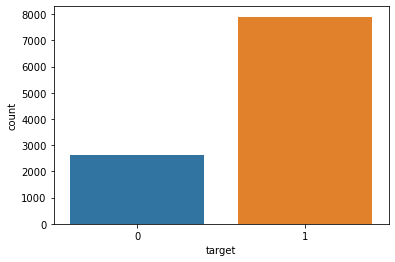

In [279]:
sns.countplot(total_df['target'])

---
- SMOTE method used to adjust class imbalance

In [280]:
oversample = SMOTE()
X, y = oversample.fit_resample(total_df, total_df['target'])

/Users/doguma/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

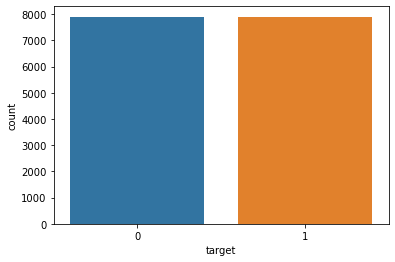

In [281]:
#Oversampling the data
smote = SMOTE(random_state = 3)
#Creating a new Oversampling Data Frame
oversampled = pd.DataFrame(X)
sns.countplot(oversampled['target'])

In [282]:
len(oversampled)

15806

In [283]:
oversampled.to_csv('02032022/smote_1mo.csv', mode='a')

---
- **MORE negative samples created (large amount)**
- twice or three times the length of df_oversampler columns

In [284]:
neg_samples2 = create_neg_samples(len(oversampled)*2)

oversampled2 = oversampled.append(neg_samples2)

# total ratio of 5:1 (no accident : accident) - 17% of getting into car accident

/var/folders/g5/grw4k9x12rbf2r7lsfh6pc480000gn/T/ipykernel_1493/2680001660.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  neg_samples[i] = temp


/Users/doguma/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

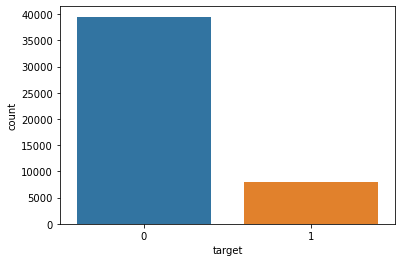

In [285]:
sns.countplot(oversampled2['target'])

In [286]:
oversampled2.to_csv('02032022/negboost_1mo.csv', mode='a')